# 2D Maxwell Solver & Animation


In [10]:
%matplotlib inline
import numpy as np

import maxwell_2d

# important to plot
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from celluloid import Camera
from clawpack.petclaw import Solution

sol = Solution()

# output animation as html5
rc('animation', html='html5')

plt.style.use('dark_background')

interactive = False
file_format = 'hdf5'
file_path = './_output'
file_prefix = 'claw'
read_aux = True
claw = None

# animation function. This is called sequentially
def get_solution(i, state = 0):
    if (interactive and claw is not None):
        solution = claw.frames[i].states[state]
    else:
        sol.read(i, path = file_path, file_prefix = file_prefix, file_format = file_format, read_aux = read_aux)
        solution = sol.states[-1]
        sol.states.clear()
    return solution

def plot_q(frame, x, y, q = 1, ax = None, title = None):
    data = get_solution(frame).get_q_global()
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('frame '+str(frame));
    im = ax.pcolormesh(x, y, data[q], shading = 'auto', animated = True);
    return im
    
def pcolor_q(i, ax, x, y, vmin = None, vmax = None, fig = None, colorbar = False):
    data = get_solution(i).get_q_global()
    for k in range(3):
        ax[k].cla()
        im = ax[k].pcolormesh(x, y, data[k], shading = 'auto', vmin = vmin[k], vmax = vmax[k])
        if colorbar:
            fig.colorbar(im, ax = ax[k])
        ax[k].grid(True)
        ax[k].set_title('q = ' + str(k) + ' @ frame = ' + str(i))
        ax[k].set_ylabel('y')
        ax[k].set_xlabel('x')
    return

def pcolor_q_and_trace(i, ax, x, y, vmin = None, vmax = None, fig = None, colorbar = False, trace_axis = 1, method = 'mean'):
    data = get_solution(i).get_q_global()
    if isinstance(method, str): method = getattr(np, method)
    if trace_axis == 1:
        u = np.unique(x)
    else:
        u = np.unique(y)
    
    for k in range(3):
        ax[k, 0].cla()
        im = ax[k, 0].pcolormesh(x, y, data[k], shading = 'auto', vmin = vmin[k], vmax = vmax[k])
        if colorbar:
            fig.colorbar(im, ax = ax[k, 0])
        ax[k, 0].grid(True)
        ax[k, 0].set_title('q' + str(k) + ' @ frame = ' + str(i))
        ax[k, 0].set_ylabel('y')
        ax[k, 0].set_xlabel('x')
        # plot the lines using the method
        ax[k, 1].cla()
        im = ax[k, 1].plot(u, method(data[k], axis = trace_axis))
        ax[k, 0].grid(True)
        if vmin[k] != vmax[k]:
            ax[k, 1].set_ylim(vmin[k], vmax[k])
        ax[k, 1].set_xlabel('x')
        ax[k, 1].set_ylabel('q' + str(k))
    return   
    
def get_grid_centers(i):
    return get_solution(i).grid.p_centers
    
def qvlimits(num_frames, dmin_th = 1e-12, symmetric = False):
    dmax = []
    dmin = []
    for i in range(num_frames):
        data = get_solution(i).get_q_global()
        dmax.append(list(np.max(data, axis = 1).max(axis=1)))
        dmin.append(list(np.min(data, axis = 2).min(axis=1)))
    dmax = np.max(dmax, axis = 0)
    dmin = np.min(dmin, axis = 0)
    if symmetric:
        for k in range(len(dmax)):
            if np.abs(dmax[k]) > np.abs(dmin[k]):
                dmin[k] = np.sign(dmin[k]) * np.abs(dmax[k])
            else:
                dmax[k] = np.sign(dmax[k]) * np.abs(dmin[k])
    else:
        dmin[np.abs(dmin)<dmin_th] = 0
    return (dmin, dmax)

def myanimate(i, ax, x, y, vmin = None, vmax = None, trace = False, trace_axis = 1, method = 'mean', colorbar = True, fig = None):
    if trace:
        _ = pcolor_q_and_trace(i, ax, x, y, vmin = vmin, vmax = vmax, trace_axis = trace_axis, method = method, colorbar = colorbar, fig = fig)
    else:
        _ = pcolor_q(i, ax, x, y, vmin = vmin, vmax = vmax, fig = fig)


## run a simulation

In [11]:
if interactive:
    claw = maxwell_2d.em2D(num_frames = 20, heading = 'x', shape = 'pulse', verbosity = False)
    claw.keep_copy = True
    claw.tfinal = 100
    claw.run()

## visualization
### preparation

In [48]:
vmin, vmax = qvlimits(num_frames = 20, symmetric = True)
xc, yc = get_grid_centers(0)

### pcolor - visualize q's

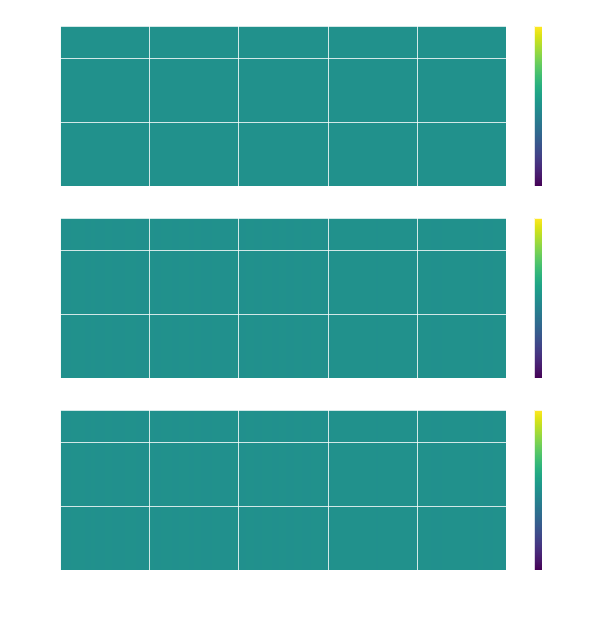

In [58]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 3, sharex = True, figsize = (10, 10))
pcolor_q(10, ax, xc, yc, fig = fig, colorbar = True, vmin = vmin, vmax = vmax)

In [53]:
%%capture out
fig, ax = plt.subplots(nrows = 3, sharex = True, figsize = (10, 10))
ani = animation.FuncAnimation(fig, myanimate, frames = 20, fargs = (ax, xc, yc, vmin, vmax), interval = 1e3)

In [54]:
HTML(ani.to_html5_video())

### pcolor & trace - visualize q's

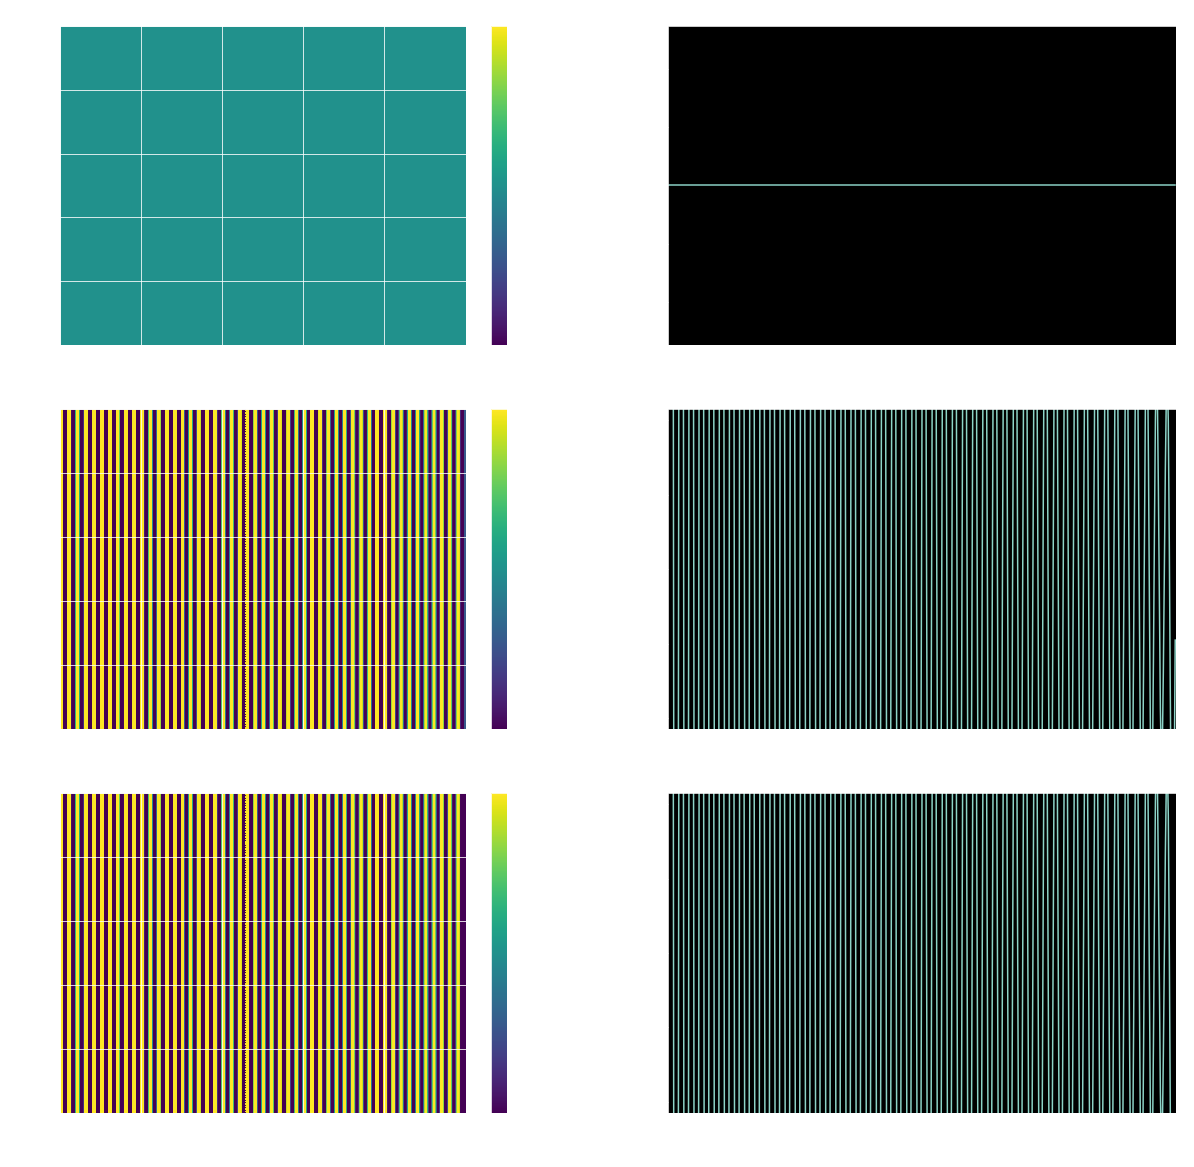

In [55]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize = (20, 20))
pcolor_q_and_trace(10, ax, xc, yc, fig = fig, colorbar = True, vmin = vmin, vmax = vmax)
# ani = animation.FuncAnimation(fig, myanimate, frames = 20, fargs = (ax, xc, yc, vmin, vmax), interval = 1e3)

In [56]:
%%capture out
fig, ax = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize = (15, 15))
ani = animation.FuncAnimation(fig, myanimate, frames = 20, fargs = (ax, xc, yc, vmin, vmax, True, 1, 'max', False, fig), interval = 5e2)

In [57]:
HTML(ani.to_html5_video())